<a href="https://www.kaggle.com/code/pradumns001/wgan-gp-evaluator?scriptVersionId=259914553" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Importing necessary modules

In [2]:
import torch
import torchvision
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchmetrics.image.fid import FrechetInceptionDistance

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import kagglehub
import os
path = kagglehub.dataset_download("splcher/animefacedataset")
path = os.path.join(path, 'images')
from PIL import Image

normal_params = [np.array([0.5,0.5,0.5]), np.array([0.5,0.5,0.5])] # Mean and std
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

/home/inauxi/PyFolder/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 395M/395M [00:50<00:00, 8.23MB/s] 

Extracting files...


cuda


## FID and dataset

In [6]:
# Defining Frechet's Inception Distance
fid = FrechetInceptionDistance(feature=192).to(device)

# Composing transorms
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

# A function to map [-1,1] --> [0, 255]
def unnorm(x):
    return (127.5 * (x + 1)).clamp(0, 255).to(torch.uint8)

# Custom Dataset class
class AnimeFaces(Dataset):
    def __init__(self, data_dir, transform = None):
        self.data_dir = data_dir
        self.transform = transform
        self.locs = os.listdir(data_dir)

    def __len__(self):
        return len(self.locs)

    def __getitem__(self, idx):
        path = os.path.join(self.data_dir, self.locs[idx])
        img = Image.open(path).convert("RGB")
        img = self.transform(img) if self.transform else img
        return img

Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /home/inauxi/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:11<00:00, 8.37MB/s]


## Definitions for Pixel norm and Generator

In [3]:
latent_dim = 100

# Pixel Norm
class PixelNorm(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + 1e-10)

# function to generate normalized random noise
def rand_noise(batch = 1):
    noise = torch.randn(batch, latent_dim, device=device)
    noise = noise / (noise.norm(dim=1, keepdim=True) + 1e-10)
    return noise

# Generator
class UpBlockOne(nn.Module):
    """
    Simple upsampling block:
      - Bilinear upsampling ( scale ×2 )
      - Convolution layer ( To extract meaningful features )
      - PReLU activation
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False),
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.PReLU()
        )

    def forward(self, x):
        return self.block(x)  # Direct bilinear upsample followed by convolution and PReLU activation


class UpBlockTwo(nn.Module):
    """
    More complex upsampling block composed of two parallel paths:
      - Path 1: Single ConvTranspose2d (stride=2) -> upsample
      - Path 2: A convolution with stride = 1 to reduce channels followed by a convolution transpose with stride 2x to up-sample
      - Outputs from both paths are concatenated along channels,
        then fused with a Conv2d followed by a PReLU activation.
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.p1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.PReLU(),
        )
        self.p2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels, (out_channels + in_channels) // 2, kernel_size=3, stride=1, padding=1),
            nn.PReLU(),
            nn.ConvTranspose2d((out_channels + in_channels) // 2, out_channels, kernel_size=4, stride=2, padding=1),
            nn.PReLU(),
        )
        self.b1 = nn.Sequential(
            nn.Conv2d(out_channels * 2, out_channels, kernel_size=3, stride=1, padding=1),
            nn.PReLU(),
        )

    def forward(self, x):
        y1 = self.p1(x)                 # Path 1
        y2 = self.p2(x)                 # Path 2
        y = torch.cat((y1, y2), dim=1)  # channel-wise concat
        return self.b1(y)               # fuse both paths


class Generator(nn.Module):
    """
    Generator network composed of:
      1. Latent → feature projection (fully connected + PixelNorm + activations)
      2. Progressive upsampling via transposed convolutions and custom blocks
      3. Parallel DCGAN-style path (dcgan1) and bilinear+conv path (dcgan2)
      4. Final convolution to RGB (3 channels), scaled with Tanh
    """
    def __init__(self):
        super().__init__()
        
        # === Latent projection & initial feature map ===
        self.layerStart = nn.Sequential(
            nn.Flatten(),                                    # Flatten latent vector

            # Mapping the latent space ( inspired from styleGAN architecture )
            nn.Linear(latent_dim, 100),
            PixelNorm(),
            nn.LeakyReLU(0.2),
            
            nn.Linear(100, 100),
            PixelNorm(),
            nn.LeakyReLU(0.2),
            
            nn.Linear(100, 512),                             # Project to 512 channels
            PixelNorm(),
            nn.LeakyReLU(0.2),
            
            nn.Unflatten(1, (512, 1, 1)),                    # Reshape -> (512, 1, 1)
            nn.ConvTranspose2d(512, 512, kernel_size=4, stride=1, padding=0),  # Upsample -> (512, 4, 4)
            nn.LeakyReLU(0.2),
        )
        
        # --- Path 1: DCGAN-style transposed convolutions + custom block --- #
        self.dcgan1 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # -> (256, 8, 8)
            nn.PReLU(),

            UpBlockTwo(256, 128),                                              # -> (128, 16, 16)

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # -> (64, 32, 32)
            nn.PReLU(),
            
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),    # -> (32, 64, 64)
            nn.PReLU()
        )
        
        # === Path 2: Bilinear upsampling + convolution blocks ===
        self.dcgan2 = nn.Sequential(
            UpBlockOne(512, 256),   # -> (256, 8, 8)
            UpBlockOne(256, 128),   # -> (128, 16, 16)
            UpBlockOne(128, 64),    # -> (64, 32, 32)
            UpBlockOne(64, 32)      # -> (32, 64, 64)
        )
        
        # === Final fusion to RGB output ===
        self.conv1 = nn.Sequential(
            nn.Conv2d(64, 3, 3, 1, 1),  # Obtaining a 3 channel RGB image
            nn.Tanh()                   # Output normalized to [-1, 1]
        )

    def forward(self, x):
        x = self.layerStart(x)          # latent vector to (512, 4, 4)
        y1 = self.dcgan1(x)             # Path 1: ConvTranspose2d-based
        y2 = self.dcgan2(x)             # Path 2: Upsample+Conv-based
        y = torch.cat((y1, y2), dim=1)  # Concatenate features (channel axis)
        return self.conv1(y)            # Final RGB image output


## Critic definition

In [4]:
# Wasserstein Loss
def wloss(D, real, fake, lambda_gp=10):
    eps = torch.rand(real.size(0), 1, 1, 1, device=real.device, requires_grad=True)
    mixed = eps * real + (1 - eps) * fake
    mixed_pred = D(mixed)
    grads = torch.autograd.grad(mixed_pred.sum(), mixed, create_graph=True)[0]
    gp = ((grads.view(grads.size(0), -1).norm(2, dim=1) - 1) ** 2).mean()
    real_pred = D(real)
    fake_pred = D(fake)
    return fake_pred.mean() - real_pred.mean() + lambda_gp * gp

# Critic definition
class Block(nn.Module):
    """
    Residual-style block with:
      - Conv2d (inp → out), LeakyReLU
      - Conv2d (out → out), LeakyReLU
      - Skip connection: output of first conv (b1) + second conv (b2)
      - PReLU activation applied after skip addition
      - MaxPool2d for downsampling (factor 2)

    Purpose:
      - Learns richer features by allowing gradient flow through skip
        connection (residual learning).
      - Reduces spatial resolution by half after feature extraction.
    """
    def __init__(self, inp, out):
        super().__init__()
        self.b1 = nn.Sequential(
            nn.Conv2d(inp,out,3,1,1),    # First convolution block
            nn.LeakyReLU(0.2),
        )
        self.b2 = nn.Sequential(
            nn.Conv2d(out,out,3,1,1),    # Second Convolution block
            nn.LeakyReLU(0.2),
        )
        self.prelu = nn.PReLU()
        self.pool = nn.MaxPool2d(2,2)

    def forward(self,x):
        x = self.b1(x)                   # First conv path
        return self.pool(self.prelu(x + self.b2(x))) # Second conv path with skip connection

class Discriminator(nn.Module):
    """
    Discriminator for GAN:
      - Input: RGB image (3×64×64)
      - Series of conv + residual blocks with downsampling
      - Global average pooling followed by fully connected layers
      - Final output: single scalar ( critic score )
    """
    def __init__(self):
        super().__init__()
        # Input size --> (*, 3, 64, 64)
        self.l1 = nn.Sequential(
            nn.Conv2d(3,64,3,1,1),        # Basic feature extraction
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2,2),            # Downsample to (64, 32, 32)

            Block(64, 128),               # Residual block → (128, 16, 16)
            Block(128, 256),              # Residual block → (256, 8, 8)
            Block(256, 384),              # Residual block → (384, 4, 4)
            nn.AdaptiveAvgPool2d((1,1)),  # Global average pooling → (384, 1, 1)
            nn.Flatten(),                 # → (384,)

            # Fully-connected layers
            nn.Linear(384, 192), # -> (192,)
            nn.PReLU(),
            nn.Linear(192, 192), # -> (192,)
            nn.PReLU(),
            # Final output scalar
            nn.Linear(192,1) # -> (1,)
        )
        
    def forward(self,x):
        return self.l1(x)

## Loading the models and dataset

Loading the generator and the critic after training as well as the dataset

We went with the generator and critic at the 31st epoch, as the sample images generated by that checkpoint seemed to be the best one...

In [7]:
# Paths to the model
generator_path = 'models/generator31.pth'
critic_path = 'models/discriminator31.pth'

# Actual models
generator = torch.load(generator_path, map_location=device, weights_only=False).to(device)
critic = torch.load(critic_path, map_location=device, weights_only=False).to(device)

# Loading the dataset
data = AnimeFaces(path, transform)
data = DataLoader(dataset=data, batch_size=512, shuffle=True , num_workers=4)
batch_count = len(data)

### Computing FID

In [7]:
# Updating with real images
for real_images in data:
    real_images = unnorm(real_images).to(device)
    fid.update(real_images, real=True)

generator.eval()
# Updating with fake images
with torch.inference_mode():
    for _ in range(batch_count):
        random = rand_noise(512)
        fake = unnorm(generator(random))
        fid.update(fake, real=False)

# FID score compute
fid_score = fid.compute()
print("FID score:", fid_score.item())

FID score: 23.9121036529541


## Defining display functions

In [8]:
def valid_plot(G, random_noise,epoch=0, rows=1, cols=6, save=True):
    """
    Visualize generated samples from the Generator during training.

    Args:
        G: The generator
        epoch: Current training epoch, shown in plot title and
            used in saved filename. Default is 0 (no title).
        rows: Number of rows in the grid
        cols: Number of columns in the grid 
        random_noise: Batch of latent noise vectors, one per image
        save: If True, saves the generated grid
    """
    with torch.inference_mode():
        fig, axs = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
        if epoch:
            plt.suptitle(f"Epoch: {epoch}")
        axs = axs.flatten() if isinstance(axs, np.ndarray) else [axs]
        for idx in range(rows * cols):
            noise = G(random_noise[idx]).squeeze(0).permute(1, 2, 0).cpu().numpy()
            mean = np.array(normal_params[0]).reshape(1, 1, 3)
            std = np.array(normal_params[1]).reshape(1, 1, 3)
            noise = np.clip(noise * std + mean, 0, 1)
            axs[idx].imshow((noise * 255).astype(np.uint8))
            axs[idx].axis('off')
        plt.tight_layout()
        if save:
            plt.savefig(f'validation_image{epoch}')
        plt.show()

def plot_imgs(rows, cols, imgs):
    """
    Takes in a list of generated images and displays them
    """
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    axs = axs.flatten()
    for idx in range(rows * cols):
        axs[idx].axis('off')
        axs[idx].imshow(imgs[idx])
    plt.tight_layout()
    plt.show()

## Displaying generated images

#### Firstly displaying the generator images with no filter

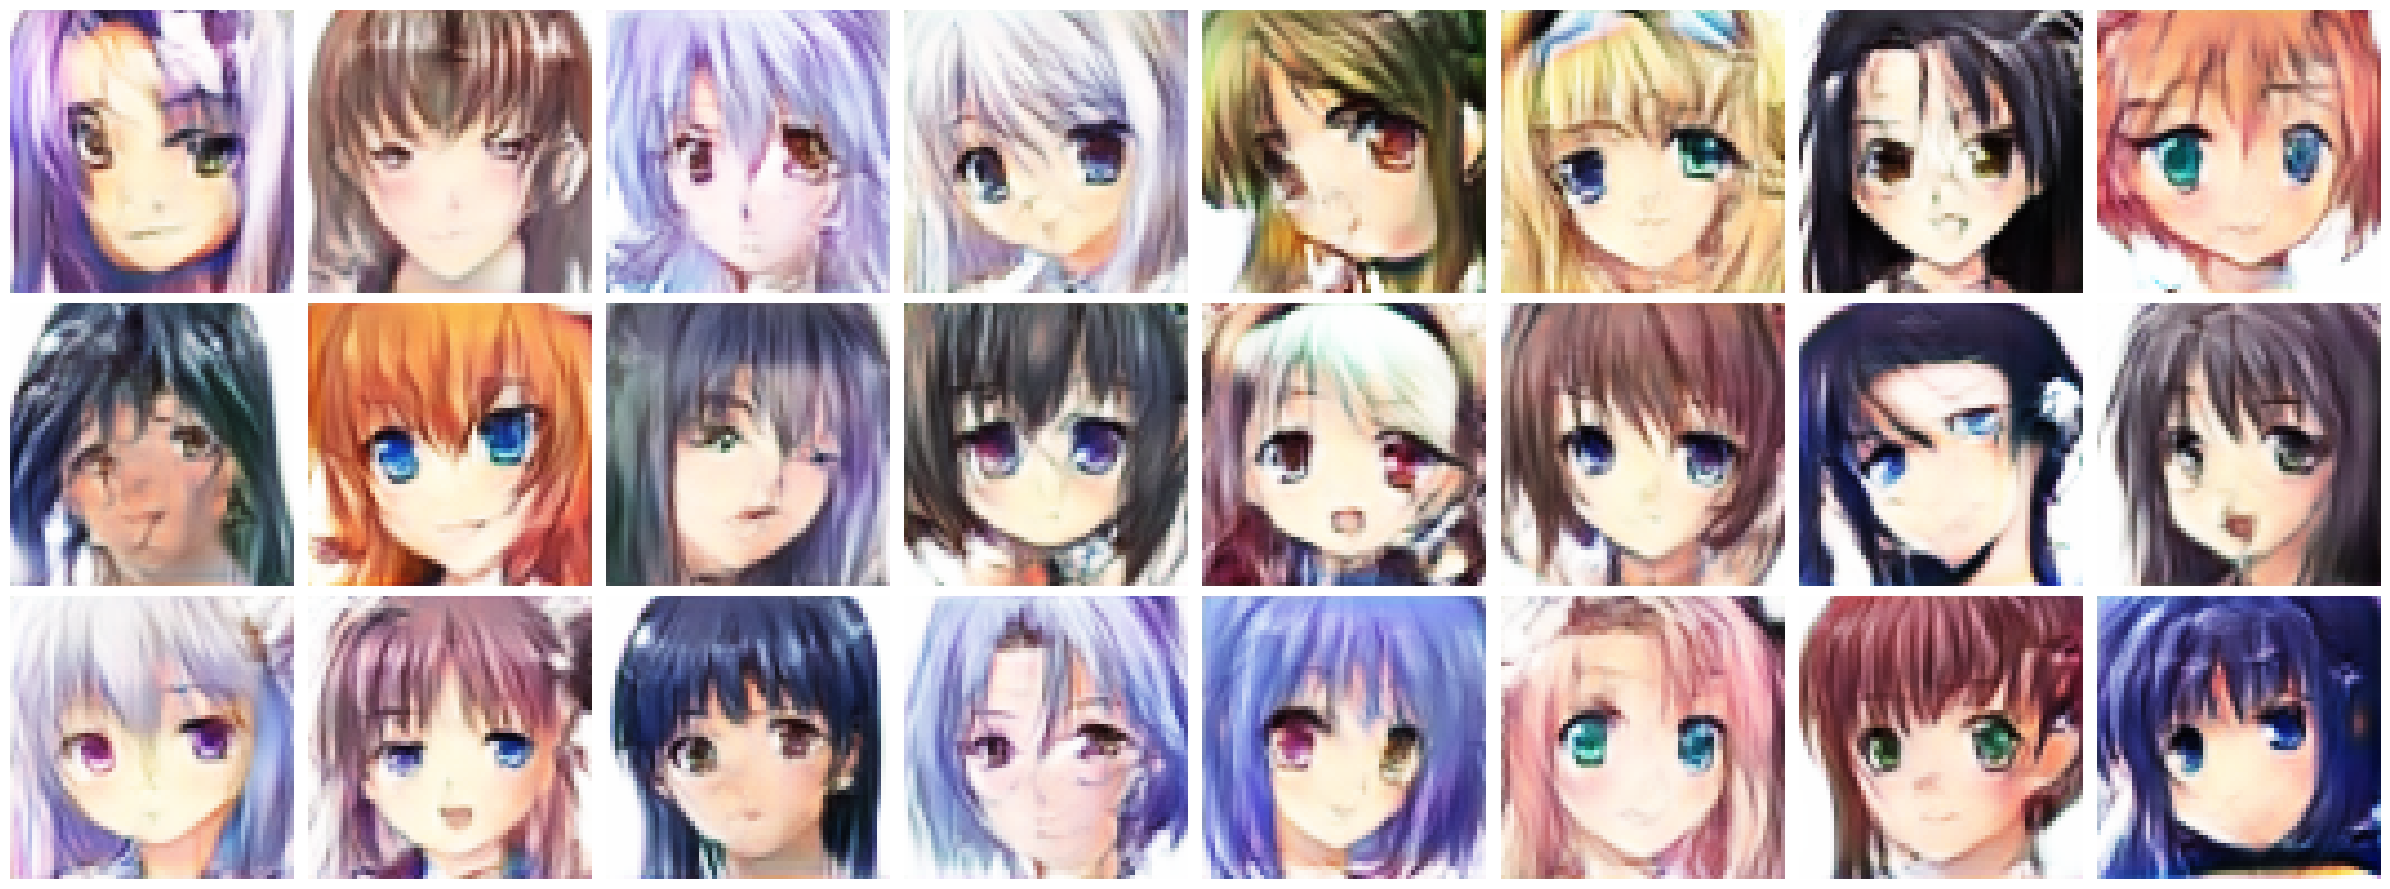

In [11]:
random_noise = [rand_noise() for _ in range(24)]
# Show-casing the best instance of the generator without any filter
valid_plot(G=generator,epoch=0, rows=3, cols=8, random_noise=random_noise, save=False)

#### Fine tuning the critic to act as a kind of filter

In [10]:
crts = 2
epochs = 2
optimizerD = torch.optim.Adam(critic.parameters(), lr=1e-5, betas=(0.2, 0.9))
gamma = 0.8 # Obvtained from hyperparameter tuning
schedD = torch.optim.lr_scheduler.StepLR(optimizerD, 1, gamma)

for _ in range(epochs):
    for imgs in data:
        for _ in range(crts):
            # Getting real and Fake images
            imgs = imgs.to(device)
            random = rand_noise(imgs.size(0))
            fake_images = generator(random).detach()
            # Back prop on critic-loss followed by gradient descent
            lossD = wloss(critic, imgs, fake_images)
            optimizerD.zero_grad()
            lossD.backward()
            optimizerD.step()
    
    schedD.step()

torch.save(critic, "filter.pth")
print('done!!')

done!!


#### Displaying the images with a filter

Filter used - We will generate 16 images per iteration and then use the critic to score them. The image with the best critic critic score is displayed.

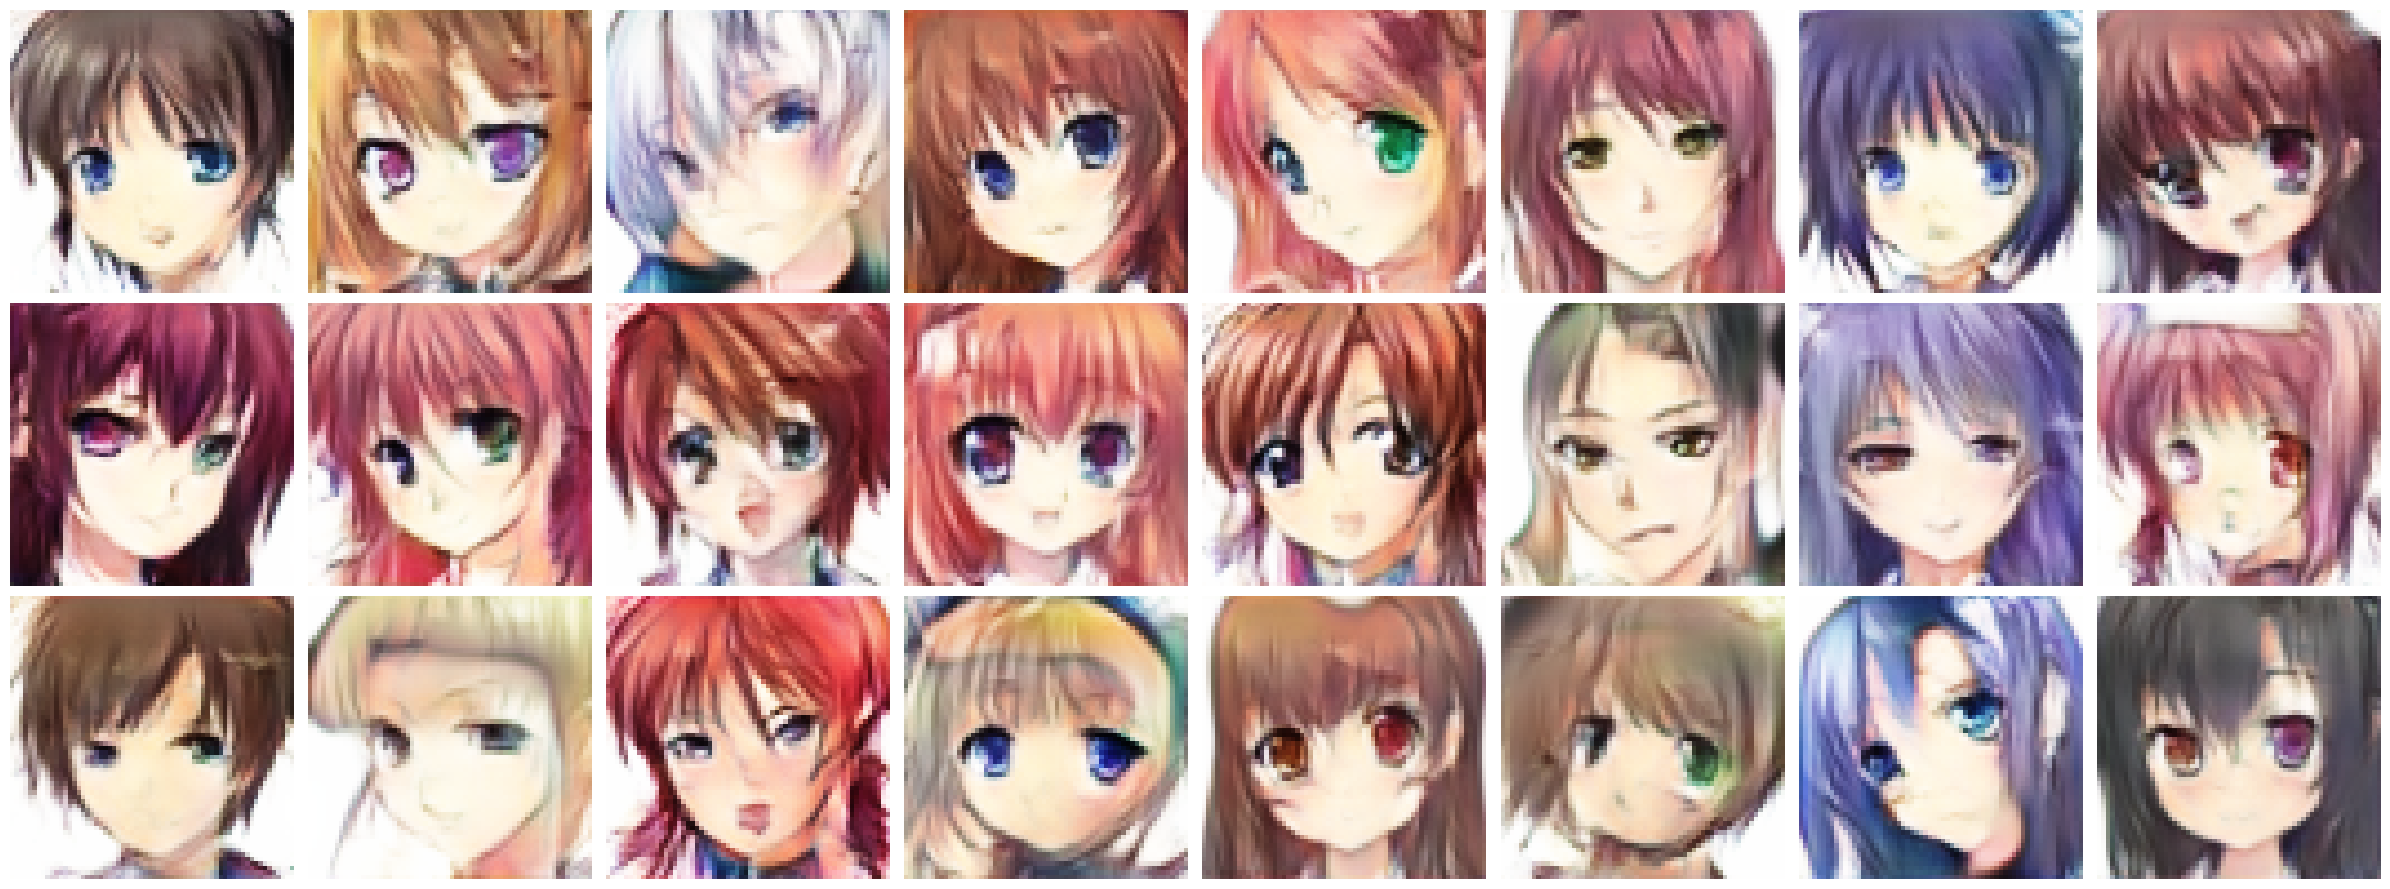

In [37]:
critic = torch.load('models/filter.pth', map_location=device, weights_only=False)

generator.eval()
critic.eval()
imgs = []
for _ in range(24):
    # Applying the filter to automatically choose the best image
    temp = -100
    temp_im = generator(rand_noise()) # done to prevent NoneType error
    for _ in range(16):
        img = generator(rand_noise())
        sc = critic(img).item()
        if temp < sc:
            temp = sc
            temp_im = img

    imgs.append(temp_im.squeeze(0).permute(1,2,0).cpu().detach().numpy()*0.5 + 0.5)
# Plotting the list of images
plot_imgs(3, 8, imgs)